# Example: Which compression method works best for different quality requirements?

> [!NOTE]
> The online laboratory has only been tested in recent Firefox and Chrome browsers. Some features may not (yet) be supported in Safari browsers.

> [!CAUTION]
> Any changes you make to this notebook will be lost once the page is closed or refreshed. Please download any files you would like to keep.

## Setting up the online laboratory

First, we import several utility packages to setup this notebook for data compression in climate science and meteorology.

Please refer back to the [01-intro.ipynb](../01-intro.ipynb) notebook for a deeper explanation.

In [1]:
from pathlib import Path

import dask
import fcbench
import numpy as np
import pandas as pd
import xarray as xr

[pyodide]: Loading Jinja2, MarkupSafe, Pillow, appdirs, asciitree, attrs, cffi, cfgrib, cftime, click, cloudpickle, cycler, dask, eccodes, field-compression-benchmark, findlibs, flexcache, flexparser, fonttools, h5py, importlib_metadata, joblib, kiwisolver, locket, matplotlib, matplotlib-pyodide, msgpack, netcdf4, numcodecs, numpy, openblas, pandas, partd, pint, pkgconfig, pycparser, pyparsing, python-dateutil, pytz, pyyaml, scikit-learn, scipy, threadpoolctl, toolz, tqdm, typing-extensions, tzdata, xarray, xarray-datatree, xeofs, xhistogram, zarr, zipp
[pyodide]: Loaded Jinja2, MarkupSafe, Pillow, appdirs, asciitree, attrs, cffi, cfgrib, cftime, click, cloudpickle, cycler, dask, eccodes, field-compression-benchmark, findlibs, flexcache, flexparser, fonttools, h5py, importlib_metadata, joblib, kiwisolver, locket, matplotlib, matplotlib-pyodide, msgpack, netcdf4, numcodecs, numpy, openblas, pandas, partd, pint, pkgconfig, pycparser, pyparsing, python-dateutil, pytz, pyyaml, scikit-learn

We also import a utility module `utils.py` from the outer parent directory.

In [2]:
import sys
sys.path.insert(0, "..")

In [3]:
import utils

[pyodide]: Loading fsspec, ipyfilite, ipywidgets, jupyterlab_widgets, kerchunk, mpmath, sympy, ujson, widgetsnbextension
[pyodide]: Loaded fsspec, ipyfilite, ipywidgets, jupyterlab_widgets, kerchunk, mpmath, sympy, ujson, widgetsnbextension
[pyodide]: Memory usage has grown to 205.2MiB (from 171.0MiB) for this notebook


In [4]:
fcbench.codecs.preload()

dask.config.set(array__chunk_size="4MiB");

Loaded the fcbench.codecs.Asinh codec ...
Loaded the fcbench.codecs.BitRound codec ...
Loaded the fcbench.codecs.FixedOffsetScale codec ...
Loaded the fcbench.codecs.Identity codec ...
Loaded the fcbench.codecs.LinearQuantize codec ...
Loaded the fcbench.codecs.Log codec ...
Loaded the fcbench.codecs.RandomProjection codec ...
Loaded the fcbench.codecs.Reinterpret codec ...
Loaded the fcbench.codecs.Round codec ...
Loaded the fcbench.codecs.SwizzleReshape codec ...
Loaded the fcbench.codecs.Sz3 codec ...
Loaded the fcbench.codecs.UniformNoise codec ...
Loaded the fcbench.codecs.Zfp codec ...
Loaded the fcbench.codecs.Zlib codec ...
Loaded the fcbench.codecs.Zstd codec ...
[pyodide]: Memory usage has grown to 246.3MiB (from 205.2MiB) for this notebook


In [5]:
import shutil
from urllib.parse import unquote as urlunquote
from urllib.parse import urlparse
from urllib.request import urlopen

download_url = "https://a3s.fi/compression.lab.climet.eu/tigge_pl_t_q_dx=2_2024_08_02.nc"
download_path = Path("data") / "02-t-q.nc"

with urlopen(download_url) as response:
    with download_path.open("wb") as file:
        shutil.copyfileobj(response, file)

In [6]:
import numpy as np
import xarray as xr

ds = utils.open_dataset(download_path)
ds

<xarray.Dataset> Size: 263kB
Dimensions:    (longitude: 180, latitude: 91, time: 1)
Coordinates:
  * longitude  (longitude) float32 720B 0.0 2.0 4.0 6.0 ... 354.0 356.0 358.0
  * latitude   (latitude) float32 364B 90.0 88.0 86.0 84.0 ... -86.0 -88.0 -90.0
  * time       (time) datetime64[ns] 8B 2024-08-12
Data variables:
    t          (time, latitude, longitude) float64 131kB dask.array<chunksize=(1, 91, 180), meta=np.ndarray>
    q          (time, latitude, longitude) float64 131kB dask.array<chunksize=(1, 91, 180), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2024-09-27 11:51:26 GMT by grib_to_netcdf-2.35.3: /opt/ecmw...
    path:         data/02-t-q.nc

In [7]:
da = ds["q"]

In [8]:
def goodness(da, da_decompressed) -> float:
    # compute the PS2NR for now, choose a better goodness estimator later
    da_min, da_max = float(da.min()), float(da.max())

    da_error = da_decompressed - da
    da_mse = float((da_error*da_error).mean())

    return np.log10(da_max - da_min) * 20.0 - np.log10(da_mse) * 10.0

In [9]:
def compression_ratio(stats):
    return round(stats[0].decoded_bytes / stats[-1].encoded_bytes, 2)

In [10]:
from matplotlib import pyplot as plt

In [11]:
import tqdm

In [12]:
bitround_ratio_goodness = []
for keepbits in tqdm.tqdm(range(0, 24)):
    compressor = [fcbench.codecs.BitRound(keepbits=keepbits), fcbench.codecs.Zlib(level=9)]
    da_decompressed, stats = fcbench.compressor.compute_dataarray_compress_decompress(
        da, compressor
    )
    bitround_ratio_goodness.append((compression_ratio(stats), goodness(da, da_decompressed)))
    del compressor
bitround_ratio_goodness = np.array(bitround_ratio_goodness)

<ipython-input-12-d445507bd121>:2: TqdmMonitorWarning: tqdm:disabling monitor support (monitor_interval = 0) due to:
can't start new thread
  for keepbits in tqdm.tqdm(range(0, 24)):
100%|██████████| 24/24 [00:01<00:00, 13.31it/s]


In [13]:
linquant_ratio_goodness = []
for bits in tqdm.tqdm(range(1, 24)):
    compressor = [fcbench.codecs.LinearQuantize(bits=bits, dtype=str(da.dtype)), fcbench.codecs.Zlib(level=9)]
    da_decompressed, stats = fcbench.compressor.compute_dataarray_compress_decompress(
        da, compressor
    )
    linquant_ratio_goodness.append((compression_ratio(stats), goodness(da, da_decompressed)))
    del compressor
linquant_ratio_goodness = np.array(linquant_ratio_goodness)

100%|██████████| 23/23 [00:01<00:00, 21.46it/s]


In [14]:
zfp_ratio_goodness = []
for rel in tqdm.tqdm([10**(-x/4) for x in range(20)]):
    compressor = [fcbench.codecs.Asinh(linear_width=1.0), fcbench.codecs.Zfp(mode="fixed-accuracy", tolerance=rel)]
    da_decompressed, stats = fcbench.compressor.compute_dataarray_compress_decompress(
        da, compressor
    )
    zfp_ratio_goodness.append((compression_ratio(stats), goodness(da, da_decompressed)))
    del compressor
zfp_ratio_goodness = np.array(zfp_ratio_goodness)

100%|██████████| 20/20 [00:00<00:00, 26.32it/s]


In [15]:
sz3_ratio_goodness = []
for rel in tqdm.tqdm([10**(-x/4) for x in range(20)]):
    compressor = [fcbench.codecs.Sz3(eb_mode="rel", eb_rel=rel)]
    da_decompressed, stats = fcbench.compressor.compute_dataarray_compress_decompress(
        da, compressor
    )
    sz3_ratio_goodness.append((compression_ratio(stats), goodness(da, da_decompressed)))
    del compressor
sz3_ratio_goodness = np.array(sz3_ratio_goodness)

100%|██████████| 20/20 [00:00<00:00, 29.59it/s]


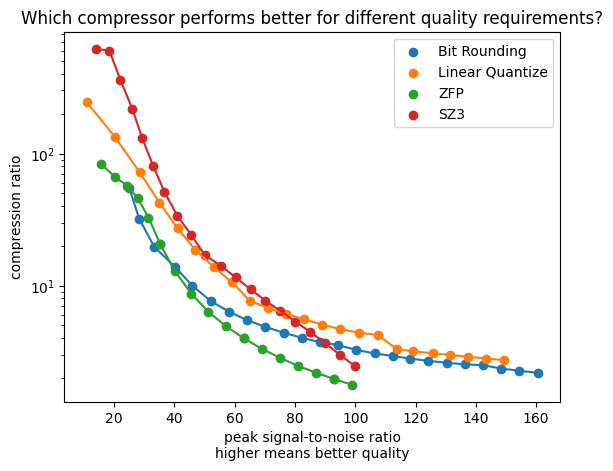

In [16]:
fig, ax = plt.subplots()

ax.set_title("Which compressor performs better for different quality requirements?")
ax.set_xlabel("peak signal-to-noise ratio\nhigher means better quality")
ax.set_ylabel("compression ratio")
ax.set_yscale("log")

ax.plot(bitround_ratio_goodness[:,1], bitround_ratio_goodness[:,0])
ax.scatter(bitround_ratio_goodness[:,1], bitround_ratio_goodness[:,0], label="Bit Rounding")

ax.plot(linquant_ratio_goodness[:,1], linquant_ratio_goodness[:,0])
ax.scatter(linquant_ratio_goodness[:,1], linquant_ratio_goodness[:,0], label="Linear Quantize")

ax.plot(zfp_ratio_goodness[:,1], zfp_ratio_goodness[:,0])
ax.scatter(zfp_ratio_goodness[:,1], zfp_ratio_goodness[:,0], label="ZFP")

ax.plot(sz3_ratio_goodness[:,1], sz3_ratio_goodness[:,0])
ax.scatter(sz3_ratio_goodness[:,1], sz3_ratio_goodness[:,0], label="SZ3")

ax.legend()

plt.show()